Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.6976
Epoch 1: val_loss improved from inf to 1.60669, saving model to model_vgg16.h5
62/62 [==============================] - 23s 339ms/step - loss: 0.6226 - accuracy: 0.6976 - val_loss: 1.6067 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.7903
Epoch 2: val_loss improved from 1.60669 to 1.23683, saving model to model_vgg16.h5
62/62 [==============================] - 21s 339ms/step - loss: 0.4608 - accuracy: 0.7903 - val_loss: 1.2368 - val_accuracy: 0.6016 - lr: 0.0010
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.8009
Epoch 3: val_loss improved from 1.23683 to 0.68218, saving model to model_vgg16.h5
62/62 [==============================] - 21s 337ms/step - loss: 0.4292 - accuracy: 0.8009 - val_loss: 0.6822 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 4/10
62/62 [====================

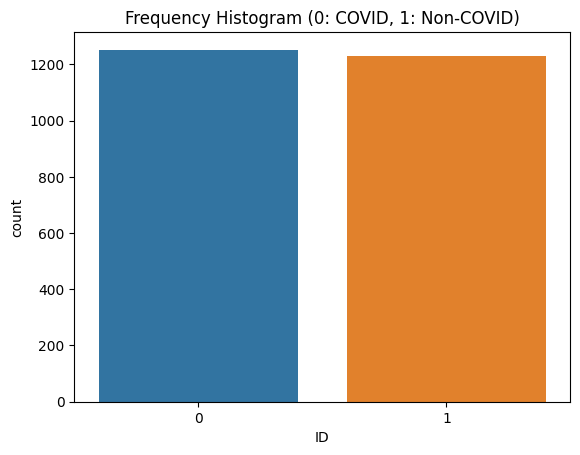

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import time
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Constants
data_dir = '/content/drive/MyDrive/Desertation/CTSCAN'
disease_types = ['COVID', 'non-COVID']
IMAGE_SIZE = 224
num_classes = len(disease_types)
Seed = 40

# Function to load and preprocess images
def preprocess_image(filepath):
    image = Image.open(filepath)
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))

    # Convert to RGB if the image has four channels
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image = np.array(image)
    image = image / 255.0
    return image

# Load data and create DataFrame
train_data = []
for index, disease_type in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, disease_type)):
        train_data.append([os.path.join(disease_type, file), index, disease_type])

train = pd.DataFrame(train_data, columns=['File', 'ID', 'Disease Type'])

# Shuffle the data
train = train.sample(frac=1, replace=False, random_state=Seed)

# Reset indices (row numbers)
train = train.reset_index(drop=True)

# Visualize class distribution
sns.countplot(x='ID', data=train).set_title("Frequency Histogram (0: COVID, 1: Non-COVID)")
#plt.show()

# Function to load and preprocess all images
X_data = []
for file in train['File'].values:
    image_path = os.path.join(data_dir, file)
    image = preprocess_image(image_path)
    X_data.append(image)

X_data = np.array(X_data)
Y_data = to_categorical(train['ID'].values, num_classes=num_classes)

# Split data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=Seed)

# Define the VGG16 model
def build_vgg16(input_shape, num_classes):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze layers to use pre-trained weights
    for layer in vgg16.layers:
        layer.trainable = False

    x = vgg16.output
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=vgg16.input, outputs=outputs)
    return model

# Build the VGG16 model
model = build_vgg16((IMAGE_SIZE, IMAGE_SIZE, 3), num_classes)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define the callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model_vgg16.h5', verbose=1, save_best_only=True)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the model with augmented images
datagen.fit(X_train)
import time
start_time = time.time()

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] // 32,
    epochs=10,
    verbose=1,
    callbacks=[annealer, checkpoint],
    validation_data=(X_val, Y_val)
)

# Evaluate the model on the validation set

Y_pred = model.predict(X_val)
end_time = time.time()
total_time = end_time - start_time
frame_rate = len(X_val) / total_time

print(f"Frame Rate: {frame_rate:.2f} samples/s")



In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

16/16 [==============================] - 1s 39ms/step
Accuracy: 0.8048289738430584
Precision: 0.7365269461077845
Recall: 0.9647058823529412
F1 Score: 0.8353140916808149
ROC AUC Score: 0.9339329120077782
Confusion Matrix:
 [[154  88]
 [  9 246]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.64      0.76       242
           1       0.74      0.96      0.84       255

    accuracy                           0.80       497
   macro avg       0.84      0.80      0.80       497
weighted avg       0.84      0.80      0.80       497

Validation Loss: 0.441575288772583


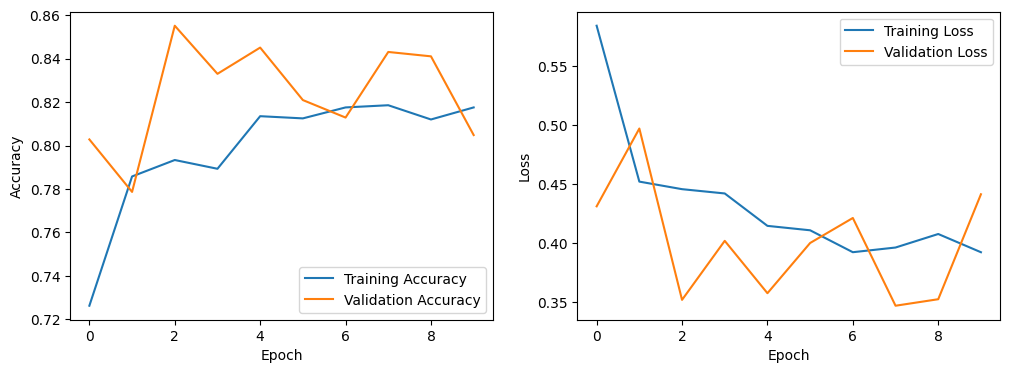

True Positive: 246
False Negative: 9
True Negative: 154
False Positive: 88
True Positive Rate: 0.9647058823529412
True Negative Rate: 0.6363636363636364



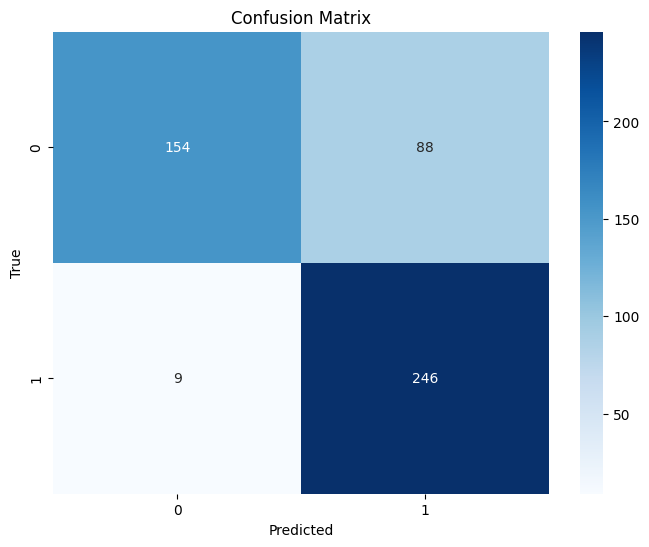

In [3]:
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score
  #Calculate evaluation metrics
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(np.argmax(Y_val, axis=1), y_pred_classes)
precision = precision_score(np.argmax(Y_val, axis=1), y_pred_classes)
recall = recall_score(np.argmax(Y_val, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(Y_val, axis=1), y_pred_classes)
roc_auc = roc_auc_score(Y_val, y_pred)
conf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), y_pred_classes)
classification_rep = classification_report(np.argmax(Y_val, axis=1), y_pred_classes)
loss_val = model.evaluate(X_val, Y_val, verbose=0)[0]

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print("Validation Loss:", loss_val)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

TP = conf_matrix[1][1]
print(f"True Positive: {TP}")

FN = conf_matrix[1][0]
print(f"False Negative: {FN}")

TN = conf_matrix[0][0]
print(f"True Negative: {TN}")

FP = conf_matrix[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, auc

# Calculate the confusion matrix
conf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score
  #Calculate evaluation metrics


accuracy = accuracy_score(np.argmax(Y_val, axis=1), y_pred_classes)
precision = precision_score(np.argmax(Y_val, axis=1), y_pred_classes)
recall = recall_score(np.argmax(Y_val, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(Y_val, axis=1), y_pred_classes)
roc_auc = roc_auc_score(Y_val, y_pred)
conf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), y_pred_classes)
classification_rep = classification_report(np.argmax(Y_val, axis=1), y_pred_classes)
loss_val = model.evaluate(X_val, Y_val, verbose=0)[0]

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print("Validation Loss:", loss_val)

Accuracy: 0.8048289738430584
Precision: 0.7365269461077845
Recall: 0.9647058823529412
F1 Score: 0.8353140916808149
ROC AUC Score: 0.9339329120077782
Confusion Matrix:
 [[154  88]
 [  9 246]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.64      0.76       242
           1       0.74      0.96      0.84       255

    accuracy                           0.80       497
   macro avg       0.84      0.80      0.80       497
weighted avg       0.84      0.80      0.80       497

Validation Loss: 0.441575288772583


1/1 [==============================] - 0s 159ms/step


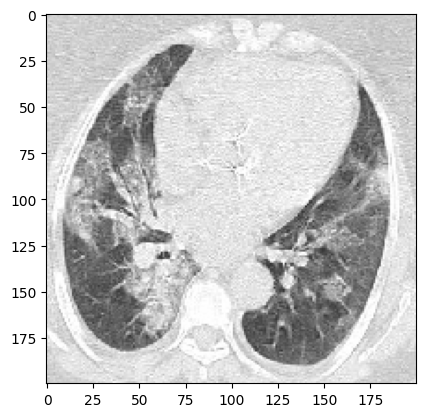

COVID-19


In [ ]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model
import numpy as np

# Load model
model = load_model('model_vgg16.h5')

# Load and preprocess image
img = image.load_img('/content/drive/MyDrive/Desertation/CTSCAN/COVID/Covid (1014).png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = image.load_img('/content/drive/MyDrive/Desertation/CTSCAN/COVID/Covid (1014).png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make prediction
prediction = model.predict(x)
plt.imshow(show_img)
plt.show()
# Determine result
if prediction[0][0] > 0.5:
    print("COVID-19")
else:
    print("not COVID-19")

1/1 [==============================] - 0s 171ms/step


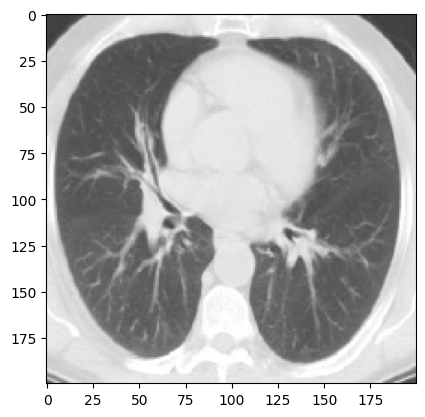

not COVID-19


In [ ]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model
import numpy as np

# Load model
model = load_model('model_vgg16.h5')

# Load and preprocess image
img = image.load_img('/content/drive/MyDrive/Desertation/CTSCAN/non-COVID/Non-Covid (100).png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = image.load_img('/content/drive/MyDrive/Desertation/CTSCAN/non-COVID/Non-Covid (100).png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make prediction
prediction = model.predict(x)
plt.imshow(show_img)
plt.show()
# Determine result
if prediction[0][0] > 0.5:
    print("COVID-19")
else:
    print("not COVID-19")